In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
data_actors = pd.read_csv('../../data/MovieSummaries/character_processed.csv')
data_actors = data_actors.rename(columns={
    'Wikipedia movie ID': "wikipedia_movie_id",
    'Freebase movie ID': "fb_movie_id",
    'Character name': "character_name",
    'Actor gender': "actor_gender",
    'Actor height (in meters)': "actor_height",
    'Actor ethnicity (Freebase ID)': "fb_actor_eth_id",
    'Actor name': "actor_name",
    'Freebase character/actor map ID': "fb_char_actor_map_id",
    'Freebase character ID': "fb_char_id",
    'Freebase actor ID': "fb_actor_id",
})

data_actors["actor_date_of_birth"] = pd.to_datetime(data_actors["actor_date_of_birth"])
data_actors["movie_release_date"] = pd.to_datetime(data_actors["movie_release_date"])

For now we do not have any information about the archetypes so I will randomly generate them

In [3]:
np.random.seed(42)
data_actors["archetype"] = np.random.randint(0, 20, size=data_actors.shape[0])

In [4]:
data_actors["age_at_film"] = (data_actors["movie_release_date"] - data_actors["actor_date_of_birth"]).dt.days / 365.25

In [5]:
data_actors["full_name_length"] = data_actors["actor_name"].apply(lambda x: 0 if pd.isna(x) else len(x))

# Question 2

Which Actor Traits Correspond to Specific Archetypes?\
Which actor traits — such as age, gender, ethnicity, and other physical attributes — are typically associated with specific archetypes? For instance, are certain traits more frequently linked to roles like heroes, villains, or mentors? Investigating these correlations can reveal patterns in casting decisions.

In [6]:
actor_traits_real_columns = ["actor_height", "age_at_film", "full_name_length"]
actor_traits_categorial_columns = ["actor_gender", "race", "ethn_name"]

In [ ]:
histograms = []

data_part = data_actors[["archetype", "actor_gender"]].dropna()

categories = data_part["actor_gender"].unique().tolist()
color_map = {
    gender: color for gender, color in zip(categories, plt.cm.tab20.colors[:len(categories)])
}

for category in categories:
    filtered_data = data_part[data_part["actor_gender"] == category]["archetype"]
    histograms.append(
        go.Histogram(
            x=filtered_data,
            name=f'Category {category}', 
            visible=False, 
            histnorm='probability density',
        )
    )

# the first is visible
histograms[0].visible = True

fig = go.Figure(data=histograms)

# create buttons
buttons = []
for i, category in enumerate(categories):
    button = {
        "label": category,
        "method": "update",
        "args": [
            {
                "visible": [j == i for j in range(len(categories))],
                "opacity": [1.0] * len(categories),
            },
            {"title": f"Histogram for {category}"},
        ]
    }
    buttons.append(button)

buttons.append(
     {
        "label": "all",
        "method": "update",
        "args": [
            {
                "visible": [True] * len(categories),
                "opacity": [0.3] * len(categories),
            },
            {"title": f"Histogram for {category}"},
        ],
    }  
)

# Add the buttons to the layout
fig.update_layout(
    updatemenus=[
        {
            "type": "dropdown",
            "direction": "down", 
            "showactive": True, 
            "buttons": buttons
        }
    ],
    title=f"Histogram by Category {categories[0]}",
    xaxis_title="Value Real",
    yaxis_title="Density",
    bargap=0.01,
    barmode='overlay',
)

fig.show()

For real data

<Axes: >

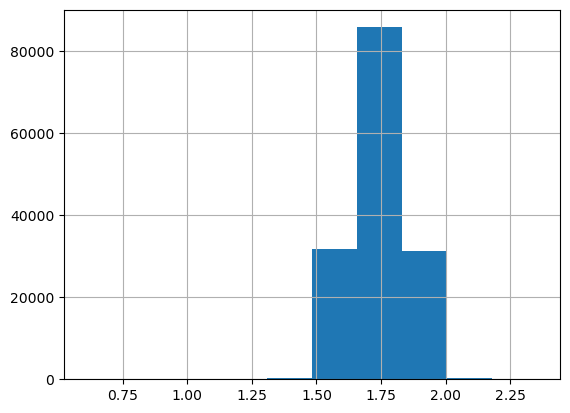

In [54]:
data_actors.actor_height[data_actors.actor_height < 3].hist()

We have many classes!

In [55]:
values = data_actors.actor_height.dropna().values
N = 10
quantiles = [np.percentile(values, i * 100 / N) for i in range(N + 1)]
for i in range(N):
    print(f"Q{i}: {quantiles[i]:.2f} - {quantiles[i + 1]:.2f}")

Q0: 0.61 - 1.61
Q1: 1.61 - 1.65
Q2: 1.65 - 1.69
Q3: 1.69 - 1.73
Q4: 1.73 - 1.75
Q5: 1.75 - 1.78
Q6: 1.78 - 1.81
Q7: 1.81 - 1.85
Q8: 1.85 - 1.88
Q9: 1.88 - 510.00


# Question 3

Do Casting Patterns Exhibit Biases Based on Actor Traits?\
Do casting patterns exhibit biases based on actor traits like age, gender, or ethnicity? Are there noticeable trends in how certain demographics are cast in specific roles? Examining these patterns can shed light on potential biases within the casting industry.

<Axes: xlabel='archetype', ylabel='age_at_film'>

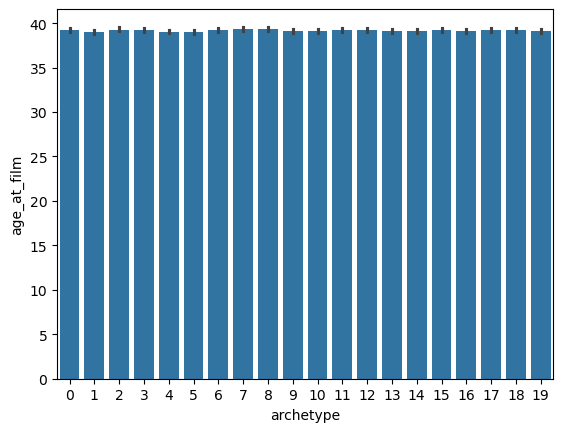

In [56]:
sns.barplot(data_actors, x="archetype", y="age_at_film")

In [ ]:
data_part = data_actors[["archetype", "age_at_film", "movie_release_date"]].dropna().copy()
data_part["year"] = data_part["movie_release_date"].dt.year
data_part = data_part[["archetype", "year", "age_at_film"]].groupby(["archetype", "year"]).mean().reset_index()

In [64]:

categories = data_part["archetype"].unique().tolist()
color_map = {
    cat: color for cat, color in zip(categories, plt.cm.tab20.colors[:len(categories)])
}

lines = []
for category in categories:
    filtered_data = data_part[data_part["archetype"] == category]
    lines.append(
        go.Scatter(
            x=filtered_data["year"],
            y=filtered_data["age_at_film"],
            name=f'{category}', 
            visible=False, 
            mode='lines',
        )
    )

# the first is visible
lines[0].visible = True

fig = go.Figure(data=lines)

# create buttons
buttons = []
for i, category in enumerate(categories):
    button = {
        "label": category,
        "method": "update",
        "args": [
            {
                "visible": [j == i for j in range(len(categories))],
                "opacity": [1.0] * len(categories),
            },
            {"title": f"Plot for {category}"},
        ]
    }
    buttons.append(button)

buttons.append(
     {
        "label": "all",
        "method": "update",
        "args": [
            {
                "visible": [True] * len(categories),
                "opacity": [0.3] * len(categories),
            },
            {"title": f"Histogram for {category}"},
        ],
    }  
)

# Add the buttons to the layout
fig.update_layout(
    updatemenus=[
        {
            "type": "dropdown",
            "direction": "down", 
            "showactive": True, 
            "buttons": buttons
        }
    ],
    title=f"Histogram by Category {categories[0]}",
    xaxis_title="Value Real",
    yaxis_title="Density",
    bargap=0.01,
    barmode='overlay',
)

fig.show()

In [ ]:
fig = px.line(data_part, x="year", y="age_at_film", color="archetype", title="Age at Film by Year")
fig.show()

In [ ]:
sns.barplot(data_actors, x="archetype", y="actor_height")

In [ ]:
sns.boxplot(data_actors, x="archetype", y="full_name_length", showfliers=False)